In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pickle
import seaborn as sns
from sklearn.utils import resample

In [24]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/isuruuy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/isuruuy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/isuruuy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
# Path to the file
file_path = '../data/ED-triage-obs-final.xlsx'  # Update with your local file path
df = pd.read_excel(file_path)

In [26]:
df = df[df['Triage'].isin([4, 5])].drop_duplicates()
df.shape

(13924, 14)

In [27]:
# Initialize NLTK resources
stop_words = set(stopwords.words('english')) - {"no", "not", "wasn't", "was not", "isn't", "is not"}
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()  # Lowercasing
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    words = word_tokenize(text)  # Tokenization
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatization
    return ' '.join(words)

# Drop unnecessary columns
df = df.drop(columns=["Blood Glucose, Capillary", "Departed", "Arrived", "Diastolic Blood Pressure", "Departure Status", "Respiratory Rate", "Temperature Tympanic"])

# Drop rows with missing 'Triage', 'Chief Complaint', 'Visit Reason', and any of the vital signs
df.dropna(subset=['Triage', 'Chief Complaint', 'Visit Reason', 'SpO2', 'Peripheral Pulse Rate', 'Systolic Blood Pressure'], inplace=True)


In [28]:
# Preprocess Visit Reason and Chief Complaint
df['Visit Reason'] = df['Visit Reason'].apply(preprocess_text)
df['Chief Complaint'] = df['Chief Complaint'].apply(preprocess_text)

# Combine Visit Reason and Chief Complaint
df['combined_text'] = df['Visit Reason'] + ' ' + df['Chief Complaint']

# Preprocess the combined_text column
sentences = df['combined_text'].apply(lambda x: x.split())

In [29]:
# Step 2: Train Word2Vec model on the combined_text column
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4, seed=42)

word2vec_model_path = "../models/logistic-regression/spe/word2vec.model"
word2vec_model.save(word2vec_model_path)
print(f"Word2Vec model saved at {word2vec_model_path}")

# Convert combined_text to a vector by averaging word embeddings
def get_sentence_embedding(sentence, model):
    words = sentence.split()
    word_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(word_vecs) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vecs, axis=0)

df['text_embedding'] = df['combined_text'].apply(lambda x: get_sentence_embedding(x, word2vec_model))

Word2Vec model saved at ../models/logistic-regression/spe/word2vec.model


In [30]:
# Extract the vital signs
vital_signs = df[['SpO2', 'Peripheral Pulse Rate', 'Systolic Blood Pressure']].values

# Step 2: Apply RobustScaler to the vital signs data
scaler_vitals = RobustScaler()
vital_signs_scaled = scaler_vitals.fit_transform(vital_signs)

In [31]:
# Step 4: Scale the text embeddings and vital signs separately
scaler_embeddings = StandardScaler()
text_embeddings_scaled = scaler_embeddings.fit_transform(np.vstack(df['text_embedding']))

# Save the scalers
scaler_embeddings_path = "../models/logistic-regression/spe/scaler-embeddings.pkl"
with open(scaler_embeddings_path, "wb") as f:
    pickle.dump(scaler_embeddings, f)
print(f"Scaler for embeddings saved at {scaler_embeddings_path}")

scaler_vitals_path = "../models/logistic-regression/spe/scaler-vitals.pkl"
with open(scaler_vitals_path, "wb") as f:
    pickle.dump(scaler_vitals, f)
print(f"Scaler for vitals saved at {scaler_vitals_path}")

# Combine the scaled text embeddings and scaled vital signs
X = np.hstack((text_embeddings_scaled, vital_signs_scaled))

Scaler for embeddings saved at ../models/logistic-regression/spe/scaler-embeddings.pkl
Scaler for vitals saved at ../models/logistic-regression/spe/scaler-vitals.pkl


In [32]:
y = df['Triage']

In [33]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/var/folders/w3/xg76b7154812409chqhw5_5w0000gn/T/ipykernel_84739/3099617725.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='pastel')


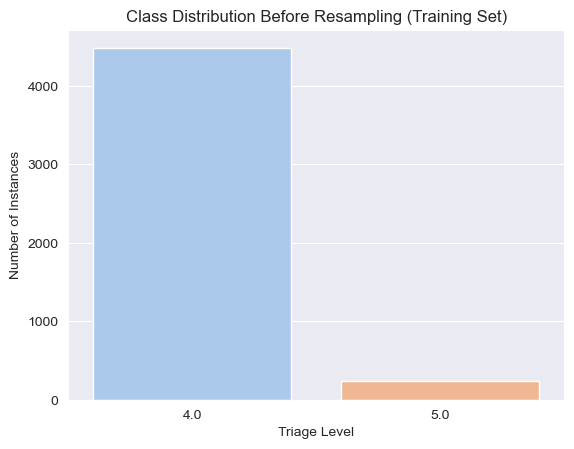

In [34]:
sns.countplot(x=y_train, palette='pastel')
plt.title('Class Distribution Before Resampling (Training Set)')
plt.xlabel('Triage Level')
plt.ylabel('Number of Instances')
plt.show()

/var/folders/w3/xg76b7154812409chqhw5_5w0000gn/T/ipykernel_84739/3921553592.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_resampled, palette='pastel')


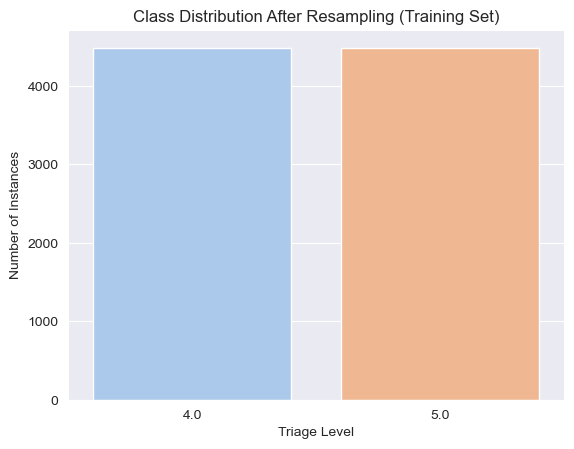

In [35]:
# Combine X_train and y_train into a single DataFrame for resampling
train_df = pd.DataFrame(X_train)
train_df['Triage'] = y_train.values

# Separate majority and minority classes in the training set
majority = train_df[train_df['Triage'] == 4]
minority = train_df[train_df['Triage'] == 5]

# Oversample the minority class by duplication
minority_oversampled = resample(minority, 
                                replace=True, 
                                n_samples=len(majority), 
                                random_state=42)

# Combine oversampled minority with the majority class
balanced_train_df = pd.concat([majority, minority_oversampled])

# Separate features and labels in the balanced training set
X_train_resampled = balanced_train_df.drop(columns=['Triage']).values
y_train_resampled = balanced_train_df['Triage'].values

sns.countplot(x=y_train_resampled, palette='pastel')
plt.title('Class Distribution After Resampling (Training Set)')
plt.xlabel('Triage Level')
plt.ylabel('Number of Instances')
plt.show()

In [36]:
# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Save the Logistic Regression model
model_path = "../models/logistic-regression/spe/logistic_regression_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(model, f)
print(f"Logistic Regression model saved at {model_path}")

# Make predictions on the test set
y_pred = model.predict(X_test)

Logistic Regression model saved at ../models/logistic-regression/spe/logistic_regression_model.pkl


In [37]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7064297800338409
Classification Report:
              precision    recall  f1-score   support

         4.0       0.98      0.71      0.82      1136
         5.0       0.09      0.72      0.16        46

    accuracy                           0.71      1182
   macro avg       0.54      0.71      0.49      1182
weighted avg       0.95      0.71      0.80      1182



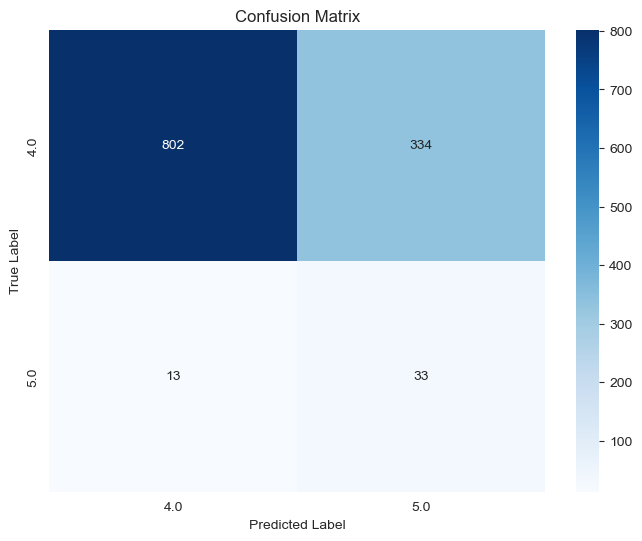

In [38]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=sorted(y_test.unique()), yticklabels=sorted(y_test.unique()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [39]:
# Assuming y_test are the true labels and y_pred are the predicted labels
report = classification_report(y_test, y_pred, output_dict=True)

# Extract macro-averaged F1-Score and Recall
macro_f1_score = report['macro avg']['f1-score']
macro_recall = report['macro avg']['recall']

print(f"Macro-Averaged F1-Score: {macro_f1_score}")
print(f"Macro-Averaged Recall: {macro_recall}")

Macro-Averaged F1-Score: 0.49097439321487835
Macro-Averaged Recall: 0.7116886099203918
